Try learning decoders off an engineered ensemble to see if it's sparse enough.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import make_alt_vocab, gen_feed_func, gen_added_strings

import random

In [25]:
def choose_encoders(n_neurons: int, dimensions: int, encoder_proportion: float, mean_fan1, mean_fan2):
    encoders = np.zeros((n_neurons, dimensions))

    fan1_end = int(n_neurons * encoder_proportion)

    for n_i in range(fan1_end):
        encoders[n_i] = mean_fan1 + np.random.normal(size=dimensions)*0.1

    for n_i in range(fan1_end, n_neurons):
        encoders[n_i] = mean_fan2 + np.random.normal(size=dimensions)*0.1
    
    return encoders

In [26]:
dimensions = 32
n_neurons = 1000
seed = 8
p_fan = 0.85

t_present = 0.3
dt = 0.001
n_repeats = 5

In [57]:
vocab, fan1, fan1_pair_vecs, fan2, fan2_pair_vecs, foil1, foil1_pair_vecs, foil2, foil2_pair_vecs = make_alt_vocab(16, 16, dimensions, seed, norm=True)
encoders = choose_encoders(n_neurons, dimensions, p_fan, np.mean(fan1_pair_vecs, axis=0), np.mean(fan2_pair_vecs, axis=0))

In [58]:
all_targs = gen_added_strings(fan1 + fan2)
feed_targs = all_targs * n_repeats
random.shuffle(feed_targs)

In [59]:
with nengo.Network(seed=seed) as train_model:
    stim = nengo.Node(gen_feed_func(vocab, feed_targs, t_present))
    correct = nengo.Node(gen_feed_func(vocab, feed_targs, t_present))
    output = nengo.Node(size_in=dimensions)

    mem = nengo.Ensemble(n_neurons, dimensions, encoders=encoders)
    err_node = nengo.Node(size_in=dimensions)
    
    nengo.Connection(stim, mem, synapse=None)
    conn_out = nengo.Connection(mem, output, learning_rule_type=nengo.PES(learning_rate=3e-4))
    
    nengo.Connection(output, err_node, synapse=None)
    nengo.Connection(correct, err_node, transform=-1, synapse=None)
    nengo.Connection(err_node, conn_out.learning_rule)

    p_dec = nengo.Probe(conn_out, 'weights', sample_every=t_present/2)
    p_out = nengo.Probe(output)

In [60]:
with nengo.Simulator(train_model) as train_sim:
    train_sim.run(len(feed_targs) * t_present)

dec = train_sim.data[p_dec][-1]

Building finished in 0:00:01.                                                                                           
Simulating finished in 0:00:44.                                                                                         


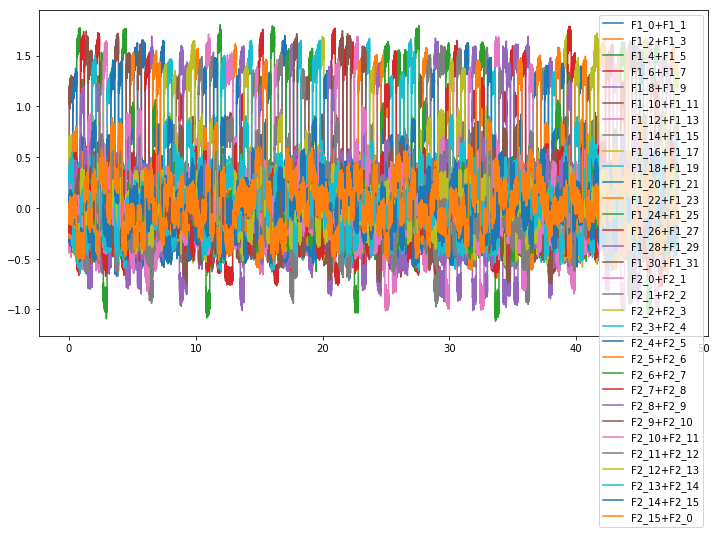

In [61]:
plt.figure(figsize=(12, 6))
plt.plot(train_sim.trange(), spa.similarity(train_sim.data[p_out], fan1_pair_vecs+fan2_pair_vecs))
plt.legend(all_targs)

In [62]:
with nengo.Network(seed=seed) as test_model:
    stim = nengo.Node(gen_feed_func(vocab, all_targs, t_present))
    correct = nengo.Node(gen_feed_func(vocab, all_targs, t_present))
    output = nengo.Node(size_in=dimensions)

    mem = nengo.Ensemble(n_neurons, dimensions, encoders=encoders)
    
    nengo.Connection(stim, mem, synapse=None)
    nengo.Connection(mem.neurons, output, transform=dec)
    
    p_out = nengo.Probe(output, synapse=0.05)
    p_cor = nengo.Probe(correct)

In [63]:
with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(all_targs)*t_present)

Building finished in 0:00:01.                                                                                           
Simulating finished in 0:00:08.                                                                                         


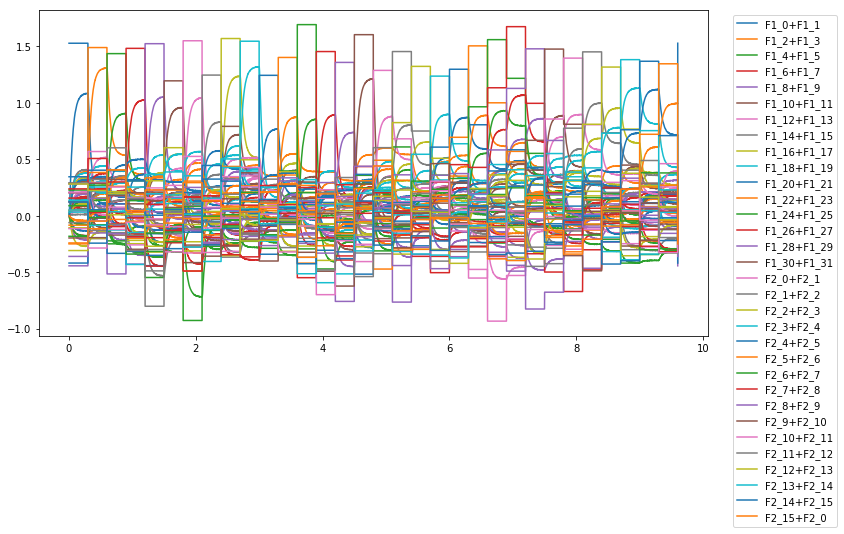

In [70]:
plt.figure(figsize=(12, 6))
plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_out], fan1_pair_vecs+fan2_pair_vecs))

plt.gca().set_prop_cycle(None)

plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_cor], fan1_pair_vecs+fan2_pair_vecs))
plt.legend(all_targs, bbox_to_anchor=(1.2, 1.0))

How much does the decoded output differ from the ideal?

In [68]:
err = np.sum(np.abs(test_sim.data[p_out] - test_sim.data[p_cor]), axis=1)
err.shape

(9600,)

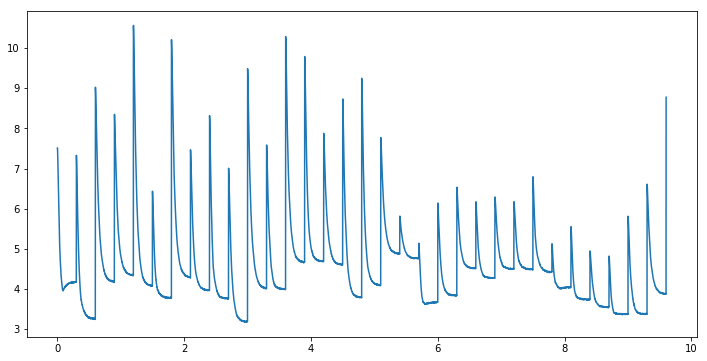

In [71]:
plt.figure(figsize=(12, 6))
plt.plot(test_sim.trange(), err)

# It worked, but not in the way I wanted

Somehow, the chosen encoders were sparse enough to learn off of, however the error for FAN1 is considerably larger than for FAN2.